
=== Обработка модели: LinearRegression ===
Усредненный max_error (CV): 0.275455
Max_error (тест): 0.180587
RMSE (тест): 0.108851

=== Обработка модели: Ridge ===
Лучшие параметры: {'ridge__alpha': 0.001}
Усредненный max_error (CV): 0.275456
Max_error (тест): 0.180587
RMSE (тест): 0.108851

=== Обработка модели: Lasso ===
Лучшие параметры: {'lasso__alpha': 0.001}
Усредненный max_error (CV): 0.276286
Max_error (тест): 0.180688
RMSE (тест): 0.108330

=== Обработка модели: ElasticNet ===
Лучшие параметры: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.1}
Усредненный max_error (CV): 0.275570
Max_error (тест): 0.180601
RMSE (тест): 0.108771


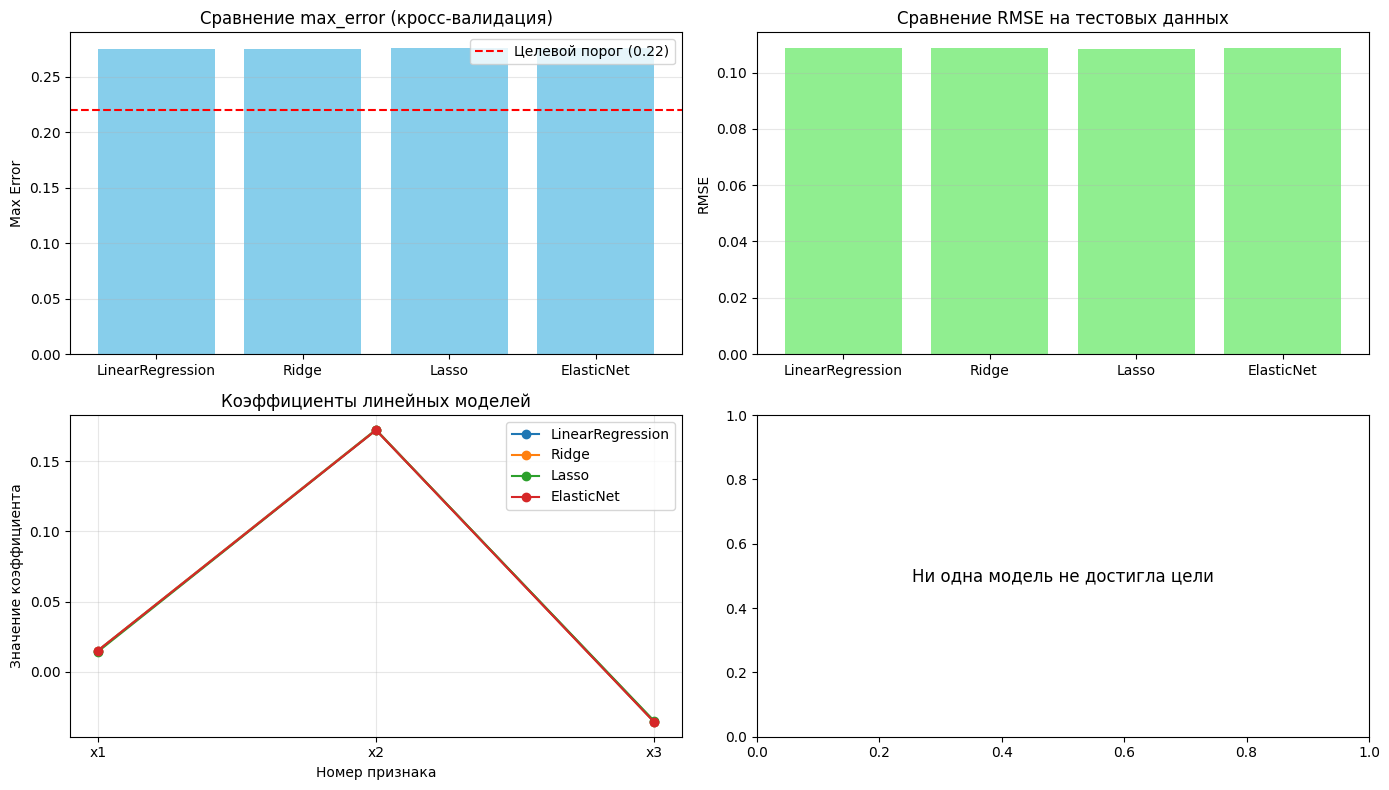


Итоговые результаты:

Модель: LinearRegression
Статус: ❌ Не удовлетворяет
Усредненный max_error: 0.275455
Параметры: N/A

Модель: Ridge
Статус: ❌ Не удовлетворяет
Усредненный max_error: 0.275456
Параметры: {'ridge__alpha': 0.001}

Модель: Lasso
Статус: ❌ Не удовлетворяет
Усредненный max_error: 0.276286
Параметры: {'lasso__alpha': 0.001}

Модель: ElasticNet
Статус: ❌ Не удовлетворяет
Усредненный max_error: 0.275570
Параметры: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.1}

НИ ОДНА ЛИНЕЙНАЯ МОДЕЛЬ НЕ ДОСТИГЛА ЦЕЛЕВОГО ПОРОГА 0.22
Рекомендуется использовать нелинейные методы (SVR, RandomForest и др.)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import max_error, mean_squared_error

# Загрузка данных
data = pd.read_csv('dataset_01.csv', sep=';')
X = data[['x1', 'x2', 'x3']]
y = data['y']

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Конфигурация моделей
models = {
    "LinearRegression": {
        "model": make_pipeline(StandardScaler(), LinearRegression()),
        "params": {}
    },
    "Ridge": {
        "model": make_pipeline(StandardScaler(), Ridge()),
        "params": {"ridge__alpha": [0.001, 0.01, 0.1, 1, 10, 100]}
    },
    "Lasso": {
        "model": make_pipeline(StandardScaler(), Lasso(max_iter=10000)),
        "params": {"lasso__alpha": [0.001, 0.01, 0.1, 1, 10, 100]}
    },
    "ElasticNet": {
        "model": make_pipeline(StandardScaler(), ElasticNet(max_iter=10000)),
        "params": {
            "elasticnet__alpha": [0.001, 0.01, 0.1, 1],
            "elasticnet__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
        }
    }
}

# Результаты
results = []
best_model = None
best_score = float('inf')

# Обучение и оценка моделей
for name, config in models.items():
    print(f"\n=== Обработка модели: {name} ===")
    
    if config["params"]:
        # Поиск по сетке параметров
        grid = GridSearchCV(
            config["model"], 
            config["params"], 
            cv=5,
            scoring='neg_max_error',
            n_jobs=-1,
            verbose=0
        )
        grid.fit(X_train, y_train)
        model = grid.best_estimator_
        best_params = grid.best_params_
        print(f"Лучшие параметры: {best_params}")
    else:
        # Без подбора параметров
        model = config["model"]
        model.fit(X_train, y_train)
        best_params = "N/A"
    
    # Кросс-валидация
    cv_scores = cross_val_score(
        model, X, y, cv=5, scoring='neg_max_error'
    )
    mean_max_error = np.mean(np.abs(cv_scores))
    
    # Оценка на тестовых данных
    y_pred = model.predict(X_test)
    test_max_error = max_error(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Сохранение результатов
    result = {
        "model_name": name,
        "model_obj": model,
        "mean_max_error": mean_max_error,
        "test_max_error": test_max_error,
        "test_rmse": test_rmse,
        "params": best_params
    }
    results.append(result)
    
    # Проверка лучшей модели
    if mean_max_error < best_score and mean_max_error <= 0.22:
        best_score = mean_max_error
        best_model = model
    
    print(f"Усредненный max_error (CV): {mean_max_error:.6f}")
    print(f"Max_error (тест): {test_max_error:.6f}")
    print(f"RMSE (тест): {test_rmse:.6f}")

# Визуализация результатов
plt.figure(figsize=(14, 8))

# График 1: Сравнение ошибок
plt.subplot(2, 2, 1)
model_names = [res["model_name"] for res in results]
max_errors = [res["mean_max_error"] for res in results]
plt.bar(model_names, max_errors, color='skyblue')
plt.axhline(y=0.22, color='r', linestyle='--', label='Целевой порог (0.22)')
plt.title('Сравнение max_error (кросс-валидация)')
plt.ylabel('Max Error')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# График 2: RMSE на тестовых данных
plt.subplot(2, 2, 2)
rmse_values = [res["test_rmse"] for res in results]
plt.bar(model_names, rmse_values, color='lightgreen')
plt.title('Сравнение RMSE на тестовых данных')
plt.ylabel('RMSE')
plt.grid(axis='y', alpha=0.3)

# График 3: Коэффициенты моделей
plt.subplot(2, 2, 3)
for res in results:
    try:
        # Извлечение коэффициентов
        if "Linear" in res["model_name"]:
            coefs = res["model_obj"].named_steps['linearregression'].coef_
        elif "Ridge" in res["model_name"]:
            coefs = res["model_obj"].named_steps['ridge'].coef_
        elif "Lasso" in res["model_name"]:
            coefs = res["model_obj"].named_steps['lasso'].coef_
        elif "ElasticNet" in res["model_name"]:
            coefs = res["model_obj"].named_steps['elasticnet'].coef_
        
        plt.plot(coefs, 'o-', label=res["model_name"])
    except:
        pass

plt.title('Коэффициенты линейных моделей')
plt.xlabel('Номер признака')
plt.ylabel('Значение коэффициента')
plt.xticks([0, 1, 2], ['x1', 'x2', 'x3'])
plt.legend()
plt.grid(True, alpha=0.3)

# График 4: Предсказания лучшей модели
plt.subplot(2, 2, 4)
if best_model:
    best_model.fit(X, y)
    y_pred = best_model.predict(X)
    plt.scatter(y, y_pred, alpha=0.6)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.title(f'Предсказания лучшей модели ({best_model.steps[-1][0]})')
    plt.xlabel('Реальные значения')
    plt.ylabel('Предсказанные значения')
    plt.grid(True)
else:
    plt.text(0.5, 0.5, 'Ни одна модель не достигла цели', 
             ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

# Вывод результатов
print("\n" + "="*60)
print("Итоговые результаты:")
for res in results:
    status = "✅ Удовлетворяет" if res["mean_max_error"] <= 0.22 else "❌ Не удовлетворяет"
    print(f"\nМодель: {res['model_name']}")
    print(f"Статус: {status}")
    print(f"Усредненный max_error: {res['mean_max_error']:.6f}")
    print(f"Параметры: {res['params']}")

if best_model:
    print("\n" + "="*60)
    print(f"ЛУЧШАЯ МОДЕЛЬ: {best_model.steps[-1][0]}")
    print(f"Усредненный max_error: {best_score:.6f}")
else:
    print("\n" + "="*60)
    print("НИ ОДНА ЛИНЕЙНАЯ МОДЕЛЬ НЕ ДОСТИГЛА ЦЕЛЕВОГО ПОРОГА 0.22")
    print("Рекомендуется использовать нелинейные методы (SVR, RandomForest и др.)")